# Analyzing Models and Tuning Hyper Parameters

## This notebook takes a stab at identifying which model to use in production

First, I import some dependencies for data manipulation; for numerical computations; for plotting charts; and finally, for a whole bunch of machine learning classification and text vectorization.

In [20]:
# Manipulates data
import pandas as pd
import re

# Performs numerical computations
import numpy as np

# Plotting charts
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Machine Learning things 
# The vectorizers are for performing analysis on word counts/frequencies
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# These are for classification and statistical analysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

Next I will load in JSON files of the subreddit posts for text analysis

In [21]:
sm = pd.read_json("../data_fetching/json2/SequelMemes.json")
pm = pd.read_json("../data_fetching/json2/PrequelMemes.json")

I will grab the posts' titles, create a feature for identifying whether a post came from r/SequelMemes, and create a corpus for vectorizing (getting word counts and frequencies for machine learning purposes).

In [22]:
sm_titles = sm[["title"]]
pm_titles = pm[["title"]]

sm_titles["is_sequel_meme"] = 1
pm_titles["is_sequel_meme"] = 0

meme_titles = pd.concat([pm_titles,sm_titles])
corpus = [title[0] for title in meme_titles[["title"]].values]

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


This is an attempt to create Pipelines and Feature Unions without using [Pipelines and Feature Unions](http://scikit-learn.org/stable/modules/pipeline.html).

I am not skilled enough (yet) to understand the intricacies of pipelines and feature unions; however, I can create the data structures I need to get something going.

I am basically testing every variation of of every parameter that can be passed into a CountVectorizer and TfidfVectorizer and then testing those against as many classifiers as I can. Ultimately, I pare down the classifiers either because some of them ran too slowly or froze my computer.

In [23]:
vectorizers_start = {
    "cvec" : CountVectorizer,
    "tfidf" : TfidfVectorizer,
}

vectorizers = {}

for key,vec in vectorizers_start.items():
    vectorizers[key] = vec(stop_words='english')
    for max_df in (0.25, 0.5, 0.75):
        vectorizers[f"{key}__max_df_of_{max_df}"] = vec(stop_words='english', max_df=max_df)
        for n_gram_range in [(1, 1), (1, 2), (1, 3), (1, 4)]:
            vectorizers[f"{key}__n_gram_range_of_{n_gram_range}"] = vec(stop_words='english', ngram_range=n_gram_range)
            vectorizers[f"{key}__n_gram_range_of_{n_gram_range}_max_df_of{max_df}"] = vec(stop_words='english', ngram_range=n_gram_range, max_df=max_df)

classifiers = {
    "bnb" : BernoulliNB(), #=> Fast and good enough score
    "mnb" : MultinomialNB(), #=> Fast and good enough score
    "logr": LogisticRegression(), #=> Best score, but super slow
#     "knn" : KNeighborsClassifier(), #=> Super overfit, not great scores
#     "tree" : DecisionTreeClassifier(), #=> Could not run successfully
    "rfc" : RandomForestClassifier(), #=> Very overfit, not much better than Naive Bayes
#     "gbc" : GradientBoostingClassifier(), #=> Not great, worse than Naive Bayes
#     "ada" : AdaBoostClassifier(), #=> Not great, worse than Naive Bayes
#     "svm" : SVC(), #=> painstakingly slow, couldn't run on my computer :/
}

# Borrowed from https://www.kaggle.com/mayu0116/hyper-parameters-tuning-of-dtree-rf-svm-knn
# and https://optunity.readthedocs.io/en/stable/notebooks/notebooks/sklearn-automated-classification.html
hyper_parameters = {
    "bnb" : {
        "alpha": np.linspace(0.0,1.0,10)
    },
    "mnb" : {
        "alpha": np.linspace(0.0,1.0,10)
    },
    "logr": {
        "penalty" : ['l1', 'l2'],
        "C": np.logspace(0, 10, 20)
    },
    "knn" : {
        'n_neighbors':[1,2,3,4,5],
        'weights':['uniform', 'distance'],
    },
    "svm" : {
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [1, 2, 10, 50],
        'gamma': [0, 1],
        'degree': [2, 5],
        'coef0': [0, 1]
    },
    "tree": {
        
    },
    "rfc":{
        
    },
    "gbc":{
        "n_estimators" : [50,100,150]
    },
    "ada":{
        "base_estimator": [BernoulliNB(), MultinomialNB(), LogisticRegression()],
        "n_estimators" : [50,100,150]
    }
}

for key,val in vectorizers.items():
    print(f"Fitting {key}")
    val.fit(corpus)
    # Transform the corpus
    X  = val.transform(corpus)
    y = meme_titles[["is_sequel_meme"]]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    for class_key, classifier in classifiers.items():
        print(f"Scores for {key} using {class_key} Classifier")
        gs = GridSearchCV(classifier, param_grid=hyper_parameters[class_key], n_jobs=-1);
        gs.fit(X_train,y_train);
        print(f"Train data: {gs.score(X_train, y_train)}")
        print(f"{gs.best_estimator_}")
        print(f"{gs.best_params_}")
        print(f"Test data: {gs.score(X_test, y_test)}")
        print(f"{gs.best_estimator_}")
        print(f"{gs.best_params_}")
        [print() for i in range(0,3)]

## Scores

I copied the outputted scores, cleaned them up in Sublime Text and created the following data structure so that I could plot the differences in training and test scores:

In [24]:
scores = [{"classifier": "cvec using bnb Classifier",
"train_score": 0.8430602767271509,
"test_score": 0.7528364210828666

},
{
"classifier": "cvec using mnb Classifier",
"train_score": 0.8424857566907646,
"test_score": 0.7539853511417492},

{
"classifier": "cvec using logr Classifier",
"train_score": 0.8680518983099536,
"test_score": 0.7529800373402269

},
{
"classifier": "cvec using rfc Classifier",
"train_score": 0.9568152439316321,
"test_score": 0.7340226913686629

},
{
"classifier": "cvec__max_df_of_0.25 using bnb Classifier",
"train_score": 0.8504811605304735,
"test_score": 0.7598736176935229

},
{
"classifier": "cvec__max_df_of_0.25 using mnb Classifier",
"train_score": 0.8490927371092066,
"test_score": 0.756426827516875

},
{
"classifier": "cvec__max_df_of_0.25 using logr Classifier",
"train_score": 0.8667113515583856,
"test_score": 0.7588683038920006

},
{
"classifier": "cvec__max_df_of_0.25 using rfc Classifier",
"train_score": 0.9548044238042802,
"test_score": 0.7465173057590119

},
{
"classifier": "cvec__n_gram_range_of_(1, 1) using bnb Classifier",
"train_score": 0.850337530521377,
"test_score": 0.7495332471635789

},
{
"classifier": "cvec__n_gram_range_of_(1, 1) using mnb Classifier",
"train_score": 0.8417676066452817,
"test_score": 0.7463736895016516

},
{
"classifier": "cvec__n_gram_range_of_(1, 1) using logr Classifier",
"train_score": 0.8698233350888113,
"test_score": 0.7509694097371823

},
{
"classifier": "cvec__n_gram_range_of_(1, 1) using rfc Classifier",
"train_score": 0.9552831905012688,
"test_score": 0.7304322849346546

},
{
"classifier": "cvec__n_gram_range_of_(1, 1)_max_df_of0.25 using bnb Classifier",
"train_score": 0.8500502705031838,
"test_score": 0.7552778974579922

},
{
"classifier": "cvec__n_gram_range_of_(1, 1)_max_df_of0.25 using mnb Classifier",
"train_score": 0.8463637669363719,
"test_score": 0.755995978744794

},
{
"classifier": "cvec__n_gram_range_of_(1, 1)_max_df_of0.25 using logr Classifier",
"train_score": 0.8682912816584478,
"test_score": 0.7555651299727129

},
{
"classifier": "cvec__n_gram_range_of_(1, 1)_max_df_of0.25 using rfc Classifier",
"train_score": 0.9570067506104275,
"test_score": 0.7291397386184116

},
{
"classifier": "cvec__n_gram_range_of_(1, 2) using bnb Classifier",
"train_score": 0.9219131517211663,
"test_score": 0.7610225477524055

},
{
"classifier": "cvec__n_gram_range_of_(1, 2) using mnb Classifier",
"train_score": 0.9152582946330253,
"test_score": 0.7590119201493609

},
{
"classifier": "cvec__n_gram_range_of_(1, 2) using logr Classifier",
"train_score": 0.9398669028582372,
"test_score": 0.764182105414333

},
{
"classifier": "cvec__n_gram_range_of_(1, 2) using rfc Classifier",
"train_score": 0.9557619571982573,
"test_score": 0.7347407726554646

},
{
"classifier": "cvec__n_gram_range_of_(1, 2)_max_df_of0.25 using bnb Classifier",
"train_score": 0.9215301383635754,
"test_score": 0.7679161281057015

},
{
"classifier": "cvec__n_gram_range_of_(1, 2)_max_df_of0.25 using mnb Classifier",
"train_score": 0.9247378752333988,
"test_score": 0.7663363492747379

},
{
"classifier": "cvec__n_gram_range_of_(1, 2)_max_df_of0.25 using logr Classifier",
"train_score": 0.9397232728491406,
"test_score": 0.7630331753554502

},
{
"classifier": "cvec__n_gram_range_of_(1, 2)_max_df_of0.25 using rfc Classifier",
"train_score": 0.9548523004739791,
"test_score": 0.7343099238833836

},
{
"classifier": "cvec__n_gram_range_of_(1, 3) using bnb Classifier",
"train_score": 0.9368027959975104,
"test_score": 0.7627459428407296

},
{
"classifier": "cvec__n_gram_range_of_(1, 3) using mnb Classifier",
"train_score": 0.9351271125580505,
"test_score": 0.7617406290392073

},
{
"classifier": "cvec__n_gram_range_of_(1, 3) using logr Classifier",
"train_score": 0.9477186766888496,
"test_score": 0.7595863851788023

},
{
"classifier": "cvec__n_gram_range_of_(1, 3) using rfc Classifier",
"train_score": 0.9571025039498252,
"test_score": 0.73273014505242

},
{
"classifier": "cvec__n_gram_range_of_(1, 3)_max_df_of0.25 using bnb Classifier",
"train_score": 0.9320151290276248,
"test_score": 0.7795490449518886

},
{
"classifier": "cvec__n_gram_range_of_(1, 3)_max_df_of0.25 using mnb Classifier",
"train_score": 0.9300043089002729,
"test_score": 0.7772511848341233

},
{
"classifier": "cvec__n_gram_range_of_(1, 3)_max_df_of0.25 using logr Classifier",
"train_score": 0.9469047733039689,
"test_score": 0.7805543587534108

},
{
"classifier": "cvec__n_gram_range_of_(1, 3)_max_df_of0.25 using rfc Classifier",
"train_score": 0.9561449705558481,
"test_score": 0.740916271721959

},
{
"classifier": "cvec__n_gram_range_of_(1, 4) using bnb Classifier",
"train_score": 0.933259922439795,
"test_score": 0.7605916989803245

},
{
"classifier": "cvec__n_gram_range_of_(1, 4) using mnb Classifier",
"train_score": 0.931632115670034,
"test_score": 0.7620278615539279

},
{
"classifier": "cvec__n_gram_range_of_(1, 4) using logr Classifier",
"train_score": 0.9492507301192129,
"test_score": 0.7677725118483413

},
{
"classifier": "cvec__n_gram_range_of_(1, 4) using rfc Classifier",
"train_score": 0.9540383970890984,
"test_score": 0.733160993824501

},
{
"classifier": "cvec__n_gram_range_of_(1, 4)_max_df_of0.25 using bnb Classifier",
"train_score": 0.9328290324125054,
"test_score": 0.7626023265833692

},
{
"classifier": "cvec__n_gram_range_of_(1, 4)_max_df_of0.25 using mnb Classifier",
"train_score": 0.9350792358883516,
"test_score": 0.7607353152376849

},
{
"classifier": "cvec__n_gram_range_of_(1, 4)_max_df_of0.25 using logr Classifier",
"train_score": 0.9484368267343324,
"test_score": 0.7644693379290536

},
{
"classifier": "cvec__n_gram_range_of_(1, 4)_max_df_of0.25 using rfc Classifier",
"train_score": 0.9549480538133768,
"test_score": 0.7410598879793192

},
{
"classifier": "cvec__max_df_of_0.5 using bnb Classifier",
"train_score": 0.843347536745344,
"test_score": 0.749102398391498

},
{
"classifier": "cvec__max_df_of_0.5 using mnb Classifier",
"train_score": 0.8473691770000479,
"test_score": 0.7455119919574896

},
{
"classifier": "cvec__max_df_of_0.5 using logr Classifier",
"train_score": 0.8673816249341696,
"test_score": 0.7521183397960649

},
{
"classifier": "cvec__max_df_of_0.5 using rfc Classifier",
"train_score": 0.9553310671709676,
"test_score": 0.740916271721959

},
{
"classifier": "cvec__n_gram_range_of_(1, 1)_max_df_of0.5 using bnb Classifier",
"train_score": 0.8505290372001724,
"test_score": 0.7534108861123079

},
{
"classifier": "cvec__n_gram_range_of_(1, 1)_max_df_of0.5 using mnb Classifier",
"train_score": 0.8506247905395701,
"test_score": 0.7502513284503806

},
{
"classifier": "cvec__n_gram_range_of_(1, 1)_max_df_of0.5 using logr Classifier",
"train_score": 0.893809546607938,
"test_score": 0.7528364210828666

},
{
"classifier": "cvec__n_gram_range_of_(1, 1)_max_df_of0.5 using rfc Classifier",
"train_score": 0.9552353138315699,
"test_score": 0.7390492603762746

},
{
"classifier": "cvec__n_gram_range_of_(1, 2)_max_df_of0.5 using bnb Classifier",
"train_score": 0.9253602719394839,
"test_score": 0.7738043946574752

},
{
"classifier": "cvec__n_gram_range_of_(1, 2)_max_df_of0.5 using mnb Classifier",
"train_score": 0.9219610283908651,
"test_score": 0.7689214419072239

},
{
"classifier": "cvec__n_gram_range_of_(1, 2)_max_df_of0.5 using logr Classifier",
"train_score": 0.9399626561976349,
"test_score": 0.7762458710326009

},
{
"classifier": "cvec__n_gram_range_of_(1, 2)_max_df_of0.5 using rfc Classifier",
"train_score": 0.9557619571982573,
"test_score": 0.7453683757001293

},
{
"classifier": "cvec__n_gram_range_of_(1, 3)_max_df_of0.5 using bnb Classifier",
"train_score": 0.9367549193278115,
"test_score": 0.764612954186414

},
{
"classifier": "cvec__n_gram_range_of_(1, 3)_max_df_of0.5 using mnb Classifier",
"train_score": 0.9264135586728587,
"test_score": 0.7649001867011346

},
{
"classifier": "cvec__n_gram_range_of_(1, 3)_max_df_of0.5 using logr Classifier",
"train_score": 0.9490113467707186,
"test_score": 0.7628895590980899

},
{
"classifier": "cvec__n_gram_range_of_(1, 3)_max_df_of0.5 using rfc Classifier",
"train_score": 0.9574376406377172,
"test_score": 0.7341663076260233

},
{
"classifier": "cvec__n_gram_range_of_(1, 4)_max_df_of0.5 using bnb Classifier",
"train_score": 0.9375688227126922,
"test_score": 0.7663363492747379

},
{
"classifier": "cvec__n_gram_range_of_(1, 4)_max_df_of0.5 using mnb Classifier",
"train_score": 0.9313927323215397,
"test_score": 0.7653310354732156

},
{
"classifier": "cvec__n_gram_range_of_(1, 4)_max_df_of0.5 using logr Classifier",
"train_score": 0.9497773734859003,
"test_score": 0.764612954186414

},
{
"classifier": "cvec__n_gram_range_of_(1, 4)_max_df_of0.5 using rfc Classifier",
"train_score": 0.956527983913439,
"test_score": 0.7367514002585093

},
{
"classifier": "cvec__max_df_of_0.75 using bnb Classifier",
"train_score": 0.8523483506487288,
"test_score": 0.7525491885681459

},
{
"classifier": "cvec__max_df_of_0.75 using mnb Classifier",
"train_score": 0.8517738306123426,
"test_score": 0.7536981186270286

},
{
"classifier": "cvec__max_df_of_0.75 using logr Classifier",
"train_score": 0.8959639967443864,
"test_score": 0.7518311072813443

},
{
"classifier": "cvec__max_df_of_0.75 using rfc Classifier",
"train_score": 0.9529851103557236,
"test_score": 0.7386184116041936

},
{
"classifier": "cvec__n_gram_range_of_(1, 1)_max_df_of0.75 using bnb Classifier",
"train_score": 0.8431081533968497,
"test_score": 0.749102398391498

},
{
"classifier": "cvec__n_gram_range_of_(1, 1)_max_df_of0.75 using mnb Classifier",
"train_score": 0.8424857566907646,
"test_score": 0.7468045382737326

},
{
"classifier": "cvec__n_gram_range_of_(1, 1)_max_df_of0.75 using logr Classifier",
"train_score": 0.8694881984009192,
"test_score": 0.7567140600315956

},
{
"classifier": "cvec__n_gram_range_of_(1, 1)_max_df_of0.75 using rfc Classifier",
"train_score": 0.9557140805285584,
"test_score": 0.7406290392072382

},
{
"classifier": "cvec__n_gram_range_of_(1, 2)_max_df_of0.75 using bnb Classifier",
"train_score": 0.9237803418394217,
"test_score": 0.7687778256498635

},
{
"classifier": "cvec__n_gram_range_of_(1, 2)_max_df_of0.75 using mnb Classifier",
"train_score": 0.9324460190549145,
"test_score": 0.7679161281057015

},
{
"classifier": "cvec__n_gram_range_of_(1, 2)_max_df_of0.75 using logr Classifier",
"train_score": 0.9397232728491406,
"test_score": 0.7686342093925033

},
{
"classifier": "cvec__n_gram_range_of_(1, 2)_max_df_of0.75 using rfc Classifier",
"train_score": 0.9548044238042802,
"test_score": 0.7466609220163722

},
{
"classifier": "cvec__n_gram_range_of_(1, 3)_max_df_of0.75 using bnb Classifier",
"train_score": 0.9315363623306363,
"test_score": 0.7657618842452966

},
{
"classifier": "cvec__n_gram_range_of_(1, 3)_max_df_of0.75 using mnb Classifier",
"train_score": 0.9331641691003973,
"test_score": 0.7637512566422519

},
{
"classifier": "cvec__n_gram_range_of_(1, 3)_max_df_of0.75 using logr Classifier",
"train_score": 0.948245320055537,
"test_score": 0.7684905931351429

},
{
"classifier": "cvec__n_gram_range_of_(1, 3)_max_df_of0.75 using rfc Classifier",
"train_score": 0.9573897639680183,
"test_score": 0.7366077840011489

},
{
"classifier": "cvec__n_gram_range_of_(1, 4)_max_df_of0.75 using bnb Classifier",
"train_score": 0.9300521855699717,
"test_score": 0.7618842452965676

},
{
"classifier": "cvec__n_gram_range_of_(1, 4)_max_df_of0.75 using mnb Classifier",
"train_score": 0.9312012256427443,
"test_score": 0.7656182679879362

},
{
"classifier": "cvec__n_gram_range_of_(1, 4)_max_df_of0.75 using logr Classifier",
"train_score": 0.9488677167616221,
"test_score": 0.7654746517305759

},
{
"classifier": "cvec__n_gram_range_of_(1, 4)_max_df_of0.75 using rfc Classifier",
"train_score": 0.9549001771436779,
"test_score": 0.7308631337067356

},
{
"classifier": "tfidf using bnb Classifier",
"train_score": 0.8464116436060708,
"test_score": 0.7503949447077409

},
{
"classifier": "tfidf using mnb Classifier",
"train_score": 0.8608703978551252,
"test_score": 0.7492460146488582

},
{
"classifier": "tfidf using logr Classifier",
"train_score": 0.8786326423134007,
"test_score": 0.7511130259945425

},
{
"classifier": "tfidf using rfc Classifier",
"train_score": 0.9559055872073539,
"test_score": 0.7426396668102829

},
{
"classifier": "tfidf__max_df_of_0.25 using bnb Classifier",
"train_score": 0.8420548666634748,
"test_score": 0.7577193738331179

},
{
"classifier": "tfidf__max_df_of_0.25 using mnb Classifier",
"train_score": 0.8536888974002969,
"test_score": 0.7558523624874336

},
{
"classifier": "tfidf__max_df_of_0.25 using logr Classifier",
"train_score": 0.8493799971273999,
"test_score": 0.7498204796782996

},
{
"classifier": "tfidf__max_df_of_0.25 using rfc Classifier",
"train_score": 0.9558098338679561,
"test_score": 0.7462300732442912

},
{
"classifier": "tfidf__n_gram_range_of_(1, 1) using bnb Classifier",
"train_score": 0.8472255469909513,
"test_score": 0.7611661640097659

},
{
"classifier": "tfidf__n_gram_range_of_(1, 1) using mnb Classifier",
"train_score": 0.8509120505577632,
"test_score": 0.7617406290392073

},
{
"classifier": "tfidf__n_gram_range_of_(1, 1) using logr Classifier",
"train_score": 0.8756642887920716,
"test_score": 0.7637512566422519

},
{
"classifier": "tfidf__n_gram_range_of_(1, 1) using rfc Classifier",
"train_score": 0.956192847225547,
"test_score": 0.7475226195605342

},
{
"classifier": "tfidf__n_gram_range_of_(1, 1)_max_df_of0.25 using bnb Classifier",
"train_score": 0.8453583568726959,
"test_score": 0.7509694097371823

},
{
"classifier": "tfidf__n_gram_range_of_(1, 1)_max_df_of0.25 using mnb Classifier",
"train_score": 0.8604873844975344,
"test_score": 0.7499640959356599

},
{
"classifier": "tfidf__n_gram_range_of_(1, 1)_max_df_of0.25 using logr Classifier",
"train_score": 0.8517259539426437,
"test_score": 0.7535545023696683

},
{
"classifier": "tfidf__n_gram_range_of_(1, 1)_max_df_of0.25 using rfc Classifier",
"train_score": 0.957485517307416,
"test_score": 0.739623725405716

},
{
"classifier": "tfidf__n_gram_range_of_(1, 2) using bnb Classifier",
"train_score": 0.91966294824532,
"test_score": 0.7686342093925033

},
{
"classifier": "tfidf__n_gram_range_of_(1, 2) using mnb Classifier",
"train_score": 0.9443673098099297,
"test_score": 0.7682033606204223

},
{
"classifier": "tfidf__n_gram_range_of_(1, 2) using logr Classifier",
"train_score": 0.9462823765978838,
"test_score": 0.7660491167600172

},
{
"classifier": "tfidf__n_gram_range_of_(1, 2) using rfc Classifier",
"train_score": 0.9563364772346435,
"test_score": 0.739192876633635

},
{
"classifier": "tfidf__n_gram_range_of_(1, 2)_max_df_of0.25 using bnb Classifier",
"train_score": 0.9295255422032843,
"test_score": 0.7686342093925033

},
{
"classifier": "tfidf__n_gram_range_of_(1, 2)_max_df_of0.25 using mnb Classifier",
"train_score": 0.9388136161248624,
"test_score": 0.7677725118483413

},
{
"classifier": "tfidf__n_gram_range_of_(1, 2)_max_df_of0.25 using logr Classifier",
"train_score": 0.9458514865705941,
"test_score": 0.7611661640097659

},
{
"classifier": "tfidf__n_gram_range_of_(1, 2)_max_df_of0.25 using rfc Classifier",
"train_score": 0.9580121606741036,
"test_score": 0.7420652017808416

},
{
"classifier": "tfidf__n_gram_range_of_(1, 3) using bnb Classifier",
"train_score": 0.9323981423852157,
"test_score": 0.7722246158265116

},
{
"classifier": "tfidf__n_gram_range_of_(1, 3) using mnb Classifier",
"train_score": 0.9514051802556615,
"test_score": 0.7667671980468189

},
{
"classifier": "tfidf__n_gram_range_of_(1, 3) using logr Classifier",
"train_score": 0.9530329870254225,
"test_score": 0.7684905931351429

},
{
"classifier": "tfidf__n_gram_range_of_(1, 3) using rfc Classifier",
"train_score": 0.9576770239862116,
"test_score": 0.7498204796782996

},
{
"classifier": "tfidf__n_gram_range_of_(1, 3)_max_df_of0.25 using bnb Classifier",
"train_score": 0.9339301958155791,
"test_score": 0.7689214419072239

},
{
"classifier": "tfidf__n_gram_range_of_(1, 3)_max_df_of0.25 using mnb Classifier",
"train_score": 0.9500167568343946,
"test_score": 0.7673416630762603

},
{
"classifier": "tfidf__n_gram_range_of_(1, 3)_max_df_of0.25 using logr Classifier",
"train_score": 0.9534160003830133,
"test_score": 0.7651874192158552

},
{
"classifier": "tfidf__n_gram_range_of_(1, 3)_max_df_of0.25 using rfc Classifier",
"train_score": 0.9584430507013932,
"test_score": 0.740485422949878

},
{
"classifier": "tfidf__n_gram_range_of_(1, 4) using bnb Classifier",
"train_score": 0.9339301958155791,
"test_score": 0.7601608502082435

},
{
"classifier": "tfidf__n_gram_range_of_(1, 4) using mnb Classifier",
"train_score": 0.9499688801646957,
"test_score": 0.7786873474077266

},
{
"classifier": "tfidf__n_gram_range_of_(1, 4) using logr Classifier",
"train_score": 0.9532244937042179,
"test_score": 0.7792618124371679

},
{
"classifier": "tfidf__n_gram_range_of_(1, 4) using rfc Classifier",
"train_score": 0.9584430507013932,
"test_score": 0.7447939106706879

},
{
"classifier": "tfidf__n_gram_range_of_(1, 4)_max_df_of0.25 using bnb Classifier",
"train_score": 0.9338823191458802,
"test_score": 0.772799080855953

},
{
"classifier": "tfidf__n_gram_range_of_(1, 4)_max_df_of0.25 using mnb Classifier",
"train_score": 0.9514051802556615,
"test_score": 0.7723682320838718

},
{
"classifier": "tfidf__n_gram_range_of_(1, 4)_max_df_of0.25 using logr Classifier",
"train_score": 0.9540862737587973,
"test_score": 0.7707884532529082

},
{
"classifier": "tfidf__n_gram_range_of_(1, 4)_max_df_of0.25 using rfc Classifier",
"train_score": 0.9586824340498875,
"test_score": 0.7449375269280483

},
{
"classifier": "tfidf__max_df_of_0.5 using bnb Classifier",
"train_score": 0.8501460238425815,
"test_score": 0.7501077121930203

},
{
"classifier": "tfidf__max_df_of_0.5 using mnb Classifier",
"train_score": 0.8512471872456552,
"test_score": 0.7479534683326152

},
{
"classifier": "tfidf__max_df_of_0.5 using logr Classifier",
"train_score": 0.8532580073730072,
"test_score": 0.7496768634209392

},
{
"classifier": "tfidf__max_df_of_0.5 using rfc Classifier",
"train_score": 0.9569109972710298,
"test_score": 0.7394801091483556

},
{
"classifier": "tfidf__n_gram_range_of_(1, 1)_max_df_of0.5 using bnb Classifier",
"train_score": 0.8481352037152295,
"test_score": 0.7581502226051989

},
{
"classifier": "tfidf__n_gram_range_of_(1, 1)_max_df_of0.5 using mnb Classifier",
"train_score": 0.8584765643701824,
"test_score": 0.7582938388625592

},
{
"classifier": "tfidf__n_gram_range_of_(1, 1)_max_df_of0.5 using logr Classifier",
"train_score": 0.8493799971273999,
"test_score": 0.7610225477524055

},
{
"classifier": "tfidf__n_gram_range_of_(1, 1)_max_df_of0.5 using rfc Classifier",
"train_score": 0.9563843539043424,
"test_score": 0.7446502944133276

},
{
"classifier": "tfidf__n_gram_range_of_(1, 2)_max_df_of0.5 using bnb Classifier",
"train_score": 0.922679178436348,
"test_score": 0.7659055005026569

},
{
"classifier": "tfidf__n_gram_range_of_(1, 2)_max_df_of0.5 using mnb Classifier",
"train_score": 0.941255326279504,
"test_score": 0.7657618842452966

},
{
"classifier": "tfidf__n_gram_range_of_(1, 2)_max_df_of0.5 using logr Classifier",
"train_score": 0.9456599798917987,
"test_score": 0.7663363492747379

},
{
"classifier": "tfidf__n_gram_range_of_(1, 2)_max_df_of0.5 using rfc Classifier",
"train_score": 0.958203667352899,
"test_score": 0.7424960505529226

},
{
"classifier": "tfidf__n_gram_range_of_(1, 3)_max_df_of0.5 using bnb Classifier",
"train_score": 0.9338344424761813,
"test_score": 0.7752405572310785

},
{
"classifier": "tfidf__n_gram_range_of_(1, 3)_max_df_of0.5 using mnb Classifier",
"train_score": 0.9486762100828267,
"test_score": 0.7742352434295562

},
{
"classifier": "tfidf__n_gram_range_of_(1, 3)_max_df_of0.5 using logr Classifier",
"train_score": 0.9527936036769282,
"test_score": 0.7670544305615395

},
{
"classifier": "tfidf__n_gram_range_of_(1, 3)_max_df_of0.5 using rfc Classifier",
"train_score": 0.9594484607650692,
"test_score": 0.7449375269280483

},
{
"classifier": "tfidf__n_gram_range_of_(1, 4)_max_df_of0.5 using bnb Classifier",
"train_score": 0.9330205390913008,
"test_score": 0.7581502226051989

},
{
"classifier": "tfidf__n_gram_range_of_(1, 4)_max_df_of0.5 using mnb Classifier",
"train_score": 0.948245320055537,
"test_score": 0.7705012207381876

},
{
"classifier": "tfidf__n_gram_range_of_(1, 4)_max_df_of0.5 using logr Classifier",
"train_score": 0.9539905204193996,
"test_score": 0.764182105414333

},
{
"classifier": "tfidf__n_gram_range_of_(1, 4)_max_df_of0.5 using rfc Classifier",
"train_score": 0.9583951740316944,
"test_score": 0.7436449806118053

},
{
"classifier": "tfidf__max_df_of_0.75 using bnb Classifier",
"train_score": 0.8505290372001724,
"test_score": 0.756426827516875

},
{
"classifier": "tfidf__max_df_of_0.75 using mnb Classifier",
"train_score": 0.8607746445157275,
"test_score": 0.7535545023696683

},
{
"classifier": "tfidf__max_df_of_0.75 using logr Classifier",
"train_score": 0.8525877339972232,
"test_score": 0.7574321413183972

},
{
"classifier": "tfidf__max_df_of_0.75 using rfc Classifier",
"train_score": 0.9562407238952458,
"test_score": 0.7356024701996265

},
{
"classifier": "tfidf__n_gram_range_of_(1, 1)_max_df_of0.75 using bnb Classifier",
"train_score": 0.8455019868817925,
"test_score": 0.7515438747666235

},
{
"classifier": "tfidf__n_gram_range_of_(1, 1)_max_df_of0.75 using mnb Classifier",
"train_score": 0.8499545171637861,
"test_score": 0.7493896309062186

},
{
"classifier": "tfidf__n_gram_range_of_(1, 1)_max_df_of0.75 using logr Classifier",
"train_score": 0.8517259539426437,
"test_score": 0.7531236535975873

},
{
"classifier": "tfidf__n_gram_range_of_(1, 1)_max_df_of0.75 using rfc Classifier",
"train_score": 0.9558098338679561,
"test_score": 0.7442194456412465

},
{
"classifier": "tfidf__n_gram_range_of_(1, 2)_max_df_of0.75 using bnb Classifier",
"train_score": 0.9233973284818308,
"test_score": 0.7692086744219445

},
{
"classifier": "tfidf__n_gram_range_of_(1, 2)_max_df_of0.75 using mnb Classifier",
"train_score": 0.9412074496098052,
"test_score": 0.7705012207381876

},
{
"classifier": "tfidf__n_gram_range_of_(1, 2)_max_df_of0.75 using logr Classifier",
"train_score": 0.962177430937904,
"test_score": 0.7651874192158552

},
{
"classifier": "tfidf__n_gram_range_of_(1, 2)_max_df_of0.75 using rfc Classifier",
"train_score": 0.959496337434768,
"test_score": 0.7386184116041936

},
{
"classifier": "tfidf__n_gram_range_of_(1, 3)_max_df_of0.75 using bnb Classifier",
"train_score": 0.9350792358883516,
"test_score": 0.764612954186414

},
{
"classifier": "tfidf__n_gram_range_of_(1, 3)_max_df_of0.75 using mnb Classifier",
"train_score": 0.9522669603102408,
"test_score": 0.7697831394513859

},
{
"classifier": "tfidf__n_gram_range_of_(1, 3)_max_df_of0.75 using logr Classifier",
"train_score": 0.9528414803466271,
"test_score": 0.7621714778112882

},
{
"classifier": "tfidf__n_gram_range_of_(1, 3)_max_df_of0.75 using rfc Classifier",
"train_score": 0.9587303107195864,
"test_score": 0.7440758293838863

},
{
"classifier": "tfidf__n_gram_range_of_(1, 4)_max_df_of0.75 using bnb Classifier",
"train_score": 0.9338823191458802,
"test_score": 0.7608789314950453

},
{
"classifier": "tfidf__n_gram_range_of_(1, 4)_max_df_of0.75 using mnb Classifier",
"train_score": 0.9520754536314454,
"test_score": 0.7664799655320982

},
{
"classifier": "tfidf__n_gram_range_of_(1, 4)_max_df_of0.75 using logr Classifier",
"train_score": 0.9548044238042802,
"test_score": 0.7663363492747379

},
{
"classifier": "tfidf__n_gram_range_of_(1, 4)_max_df_of0.75 using rfc Classifier",
"train_score": 0.9603581174893474,
"test_score": 0.7381875628321126

}]

I made a way to map the classifiers to certain colors so I can identify which is which in a chart

In [25]:
classifiers = [re.search(r'using (.*?) Classifier', score["classifier"]).group(1) for score in scores]

color_map = dict(zip(list(set(classifiers)),['#e66101','#5e3c99','#fdb863','#b2abd2']))

I embed a shortened name of the classifier into the list of dictionaries that I created above so that I can create a legend that shows the color and the differentation of each classifier.

In [26]:
for score in scores:
    score["short_class"] = re.search(r'using (.*?) Classifier', score["classifier"]).group(1)

Now I will create a dataframe of the scores and chart it so that I can see how the various classifiers generally perform.

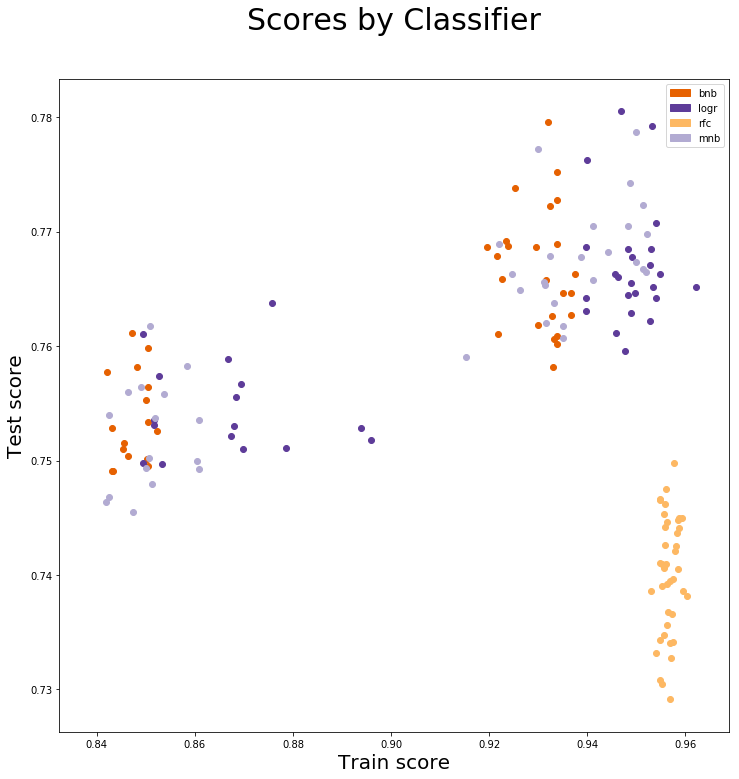

In [29]:
scores_df = pd.DataFrame(scores)

sorted_scores = scores_df.sort_values(
    by="test_score",
    ascending=False)

plt.figure(figsize=(12,12))
plt.title("Scores by Classifier", fontsize=30, pad=50)
plt.xlabel("Train score", fontsize=20)
plt.ylabel("Test score", fontsize=20)
handles = [mpatches.Patch(color=val, label=key) for key, val in color_map.items()]
plt.legend(handles=handles)
for key, val in color_map.items():
    for score in scores:
        if score["short_class"] == key:
            plt.scatter(
                x=score["train_score"],
                y=score["test_score"],
                color=val)
plt.savefig("../presentation/images/scores_by_classifier.png")
print()

Finally a look at the hyperparameters and classifiers that were the top 10

In [9]:
sorted_scores.head(10)

,classifier,short_class,test_score,train_score
30,"cvec__n_gram_range_of_(1, 3)_max_df_of0.25 usi...",logr,0.780554,0.946905
28,"cvec__n_gram_range_of_(1, 3)_max_df_of0.25 usi...",bnb,0.779549,0.932015
114,"tfidf__n_gram_range_of_(1, 4) using logr Class...",logr,0.779262,0.953224
113,"tfidf__n_gram_range_of_(1, 4) using mnb Classi...",mnb,0.778687,0.949969
29,"cvec__n_gram_range_of_(1, 3)_max_df_of0.25 usi...",mnb,0.777251,0.930004
50,"cvec__n_gram_range_of_(1, 2)_max_df_of0.5 usin...",logr,0.776246,0.939963
132,"tfidf__n_gram_range_of_(1, 3)_max_df_of0.5 usi...",bnb,0.775241,0.933834
133,"tfidf__n_gram_range_of_(1, 3)_max_df_of0.5 usi...",mnb,0.774235,0.948676
48,"cvec__n_gram_range_of_(1, 2)_max_df_of0.5 usin...",bnb,0.773804,0.925360
116,"tfidf__n_gram_range_of_(1, 4)_max_df_of0.25 us...",bnb,0.772799,0.933882
